In [11]:

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from enum import Enum
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from itertools import product
from copy import deepcopy
import matplotlib.colors as mcolors



In [12]:

def plot_series(iterations_per_episode, scores_per_episode):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(iterations_per_episode)
    plt.title("Iterations per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Iterations")

    plt.subplot(1, 2, 2)
    plt.plot(scores_per_episode)
    plt.title(f"Score per {PRINT_FREQUENCY} Episodes")
    plt.xlabel(f"Episodes time {PRINT_FREQUENCY}")
    plt.ylabel("Score")

    plt.tight_layout()
    plt.show()


In [13]:
def plot_game_board(grid):
    """
    Visualizes the game board using matplotlib.

    Args:
    - grid (2D list): The game grid.
    """
    
    # Convert the grid to numpy array for easier indexing
    grid = np.array(grid)

    # Define a colormap: list of color names
    cmap = mcolors.ListedColormap(['white', 'black', 'green', 'red', 'yellow'])  # The order has been adjusted based on the value assignments below.
    
    # Set the bounds for the colormap
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=cmap, norm=norm)

    # Hide the axis
    ax.axis('off')
    
    plt.show()

In [14]:
# Editable Globals
PLAYABLE_GRID_SIZE = 10 # Playable grid without walls.  Minimum value = 5


WALL_PENALTY = -0.1
MOVEMENT_BONUS_NUMERATOR = 1  # This is divided by the distance to the apple
APPLE_BONUS = .5
WIN_BONUS = 10
STARTING_SCORE = 0


DECAY_RATE = (1 - 1e-6)
LEARNING_RATE = 1e-2
EPSILON = 9 * 1e-1
PRINT_FREQUENCY = 2**12
BUFFER_SIZE = 4096
BATCH_SIZE = 8192
GAMMA = 0.99
EPISODES = 2**18
SEED = 42

# These globals are derived, don't edit unless refactoring
TOTAL_GRID_SIZE = PLAYABLE_GRID_SIZE + 2             # Playable Area + Walls
MAX_SNAKE_LENGTH = PLAYABLE_GRID_SIZE ** 2 - 1

EMPTY_GRID_SET = set((i, j) for i, j in product(range(1, TOTAL_GRID_SIZE - 1), repeat=2))

## initialize blank grid with empty squares (0) and walls (4)
EMPTY_STATE_NESTED_LIST = [[0 for _ in range(TOTAL_GRID_SIZE)] for _ in range(TOTAL_GRID_SIZE)]
for i in range(TOTAL_GRID_SIZE):
    EMPTY_STATE_NESTED_LIST[0][i] = EMPTY_STATE_NESTED_LIST[i][0] = EMPTY_STATE_NESTED_LIST[TOTAL_GRID_SIZE -1][i] = EMPTY_STATE_NESTED_LIST[i][TOTAL_GRID_SIZE - 1] = 1



In [15]:


class Direction(Enum):
    UP =    [1, 0, 0, 0]
    DOWN =  [0, 1, 0, 0]
    LEFT =  [0, 0, 1, 0]
    RIGHT = [0, 0, 0, 1]


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def eat_apple(snake_queue):
    """
    Generate a new apple location that's not within the snake's current position.

    Args:
    - snake_queue (list): List of tuples representing the snake's current positions.

    Returns:
    - tuple: New apple location.
    """
    available_locations = EMPTY_GRID_SET - set(snake_queue)
    new_apple_location = random.choice(list(available_locations))
    return new_apple_location

def initialize_game(starting_head_location, starting_apple_location):
    """
    Initialize the snake's starting position and the first apple's position.

    Returns:
    - snake_queue (list): List of tuples representing the snake's initial position.
    - apple_location (tuple): Initial apple location.
    """
    # Initialize the snake queue with the head location
    snake_queue = [starting_head_location]
    apple_location = starting_apple_location
    score = STARTING_SCORE
    distance_to_apple = ((starting_head_location[0]-starting_apple_location[0])**2 + (starting_head_location[1]-starting_apple_location[1])**2)**0.5
    distance_traveled_to_apple = 0
    game_over = False
    return game_over, snake_queue, apple_location, distance_traveled_to_apple, distance_to_apple, score

def update_state(snake_queue, apple_location, distance_traveled_to_apple, direction, score):
    """
    Update the snake's position based on the given direction.
    """
    
    def move_snake(snake_queue, direction):
        head_location = snake_queue[-1]
        # Update head_location based on the direction
        if direction == Direction.UP: # Up
            head_location = (head_location[0]-1, head_location[1])
        elif direction == Direction.DOWN: # Down
            head_location = (head_location[0]+1, head_location[1])
        elif direction == Direction.LEFT: # Left
            head_location = (head_location[0], head_location[1]-1)
        else: # Right
            head_location = (head_location[0], head_location[1]+1)
        return head_location

    def score_and_process_move(head_location, snake_queue, apple_location, distance_traveled_to_apple, score):
        # Check if snake ate itself or a wall
        distance_traveled_to_apple += 1
        distance_to_apple = ((head_location[0]-apple_location[0])**2 + (head_location[1]-apple_location[1])**2)**0.5

        if (head_location in snake_queue) or (head_location[0] in [0, TOTAL_GRID_SIZE - 1] or head_location[1] in [0, TOTAL_GRID_SIZE - 1]):
            score += WALL_PENALTY
            snake_queue.append(head_location)
            snake_queue.pop(0)
            return True, snake_queue, apple_location, distance_traveled_to_apple, score
        # Check if snake ate apple
        elif head_location == apple_location:
            score += APPLE_BONUS 
            apple_location = eat_apple(snake_queue)
            snake_queue.append(head_location)
            distance_traveled_to_apple = 0
        # Snake just moves
        else:
            score += MOVEMENT_BONUS_NUMERATOR // distance_to_apple
            snake_queue.append(head_location)
            snake_queue.pop(0)
        if len(snake_queue) == MAX_SNAKE_LENGTH:
            score += WIN_BONUS
            return True, snake_queue, apple_location, distance_traveled_to_apple, score
        return False, snake_queue, apple_location, distance_traveled_to_apple, score

    return score_and_process_move(move_snake(snake_queue, direction), snake_queue, apple_location, distance_traveled_to_apple, score)


In [16]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

In [17]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(
            *random.sample(self.buffer, batch_size))
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch
    
    def __len__(self):
        return len(self.buffer)

In [18]:
class DQNAgent:
    def __init__(self, input_dim, output_dim, gamma=GAMMA, learning_rate=LEARNING_RATE, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE):
        self.dqn = DQN(input_dim, output_dim).to(device)
        self.target = DQN(input_dim, output_dim).to(device)
        self.target.load_state_dict(self.dqn.state_dict())
        self.target.eval() # Set the target network to evaluation mode
        
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = EPSILON
    
    def update(self):
        if len(self.buffer) < self.batch_size:
            return
        state, action, reward, next_state, done = self.buffer.sample(self.batch_size)
        
        # Convert to tensors
        state = torch.FloatTensor(state).to(device)
        action = torch.LongTensor(action).to(device)
        reward = torch.FloatTensor(reward).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(done).to(device)
        
        # Compute Q-values
        curr_Q = self.dqn(state).gather(1, action.unsqueeze(1))
        curr_Q = curr_Q.squeeze(1)
        next_Q = self.target(next_state).max(1)[0]
        expected_Q = reward + (1 - done) * self.gamma * next_Q
        
        # Compute loss and update the network
        loss = self.loss_fn(curr_Q, expected_Q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            if random.random() > self.epsilon:
                action_index = int(self.dqn(state).max(1)[1])
            else:
                action_index = random.randint(0, 3) # Number of actions - 1

        # Map action_index to Direction enum
        
        return action_index

                
    def decay_epsilon(self):
        self.epsilon *= DECAY_RATE
        self.epsilon = max(self.epsilon, 0.01)

        # Decay the learning rate
        #self.optimizer.param_groups[0]['lr'] *= DECAY_RATE

    def get_epsilon(self):
        return self.epsilon
    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']        
    def sync_target(self):
        self.target.load_state_dict(self.dqn.state_dict())

In [19]:
def encode_state(snake_queue, apple_location, distance_traveled_to_apple, score):
    
    grid = [row[:] for row in EMPTY_STATE_NESTED_LIST]
    
    
    for segment in snake_queue:
        grid[segment[0]][segment[1]] = 2

    grid[apple_location[0]][apple_location[1]] = 3
    
    head = snake_queue[-1]
    grid[head[0]][head[1]] = 4


    # Distance to nearest obstacle
    distances_to_obstacle = {
        "left": head[1],
        "right": TOTAL_GRID_SIZE - 1 - head[1],
        "up": head[0],
        "down": TOTAL_GRID_SIZE - 1 - head[0]
    }
    
    for segment in snake_queue:
        if segment[0] == head[0]:  # Same row as head
            if 0 < segment[1] - head[1] < distances_to_obstacle["right"]:  # Segment is to the right of head
                distances_to_obstacle["right"] = segment[1] - head[1] - 1
            elif 0 < head[1] - segment[1] < distances_to_obstacle["left"]:  # Segment is to the left of head
                distances_to_obstacle["left"] = head[1] - segment[1] - 1
                
        if segment[1] == head[1]:  # Same column as head
            if 0 < segment[0] - head[0] < distances_to_obstacle["down"]:  # Segment is below head
                distances_to_obstacle["down"] = segment[0] - head[0] - 1
            elif 0 < head[0] - segment[0] < distances_to_obstacle["up"]:  # Segment is above head
                distances_to_obstacle["up"] = head[0] - segment[0] - 1

    # Distance to apple (vertical and horizontal)
    apple_dist = {
        "horizontal": apple_location[1] - head[1],
        "vertical": apple_location[0] - head[0]
    }
    
    flat_grid = [cell for row in grid for cell in row]
    
    state = flat_grid + [distances_to_obstacle[dir] for dir in ["left", "right", "up", "down"]] + [apple_dist["horizontal"], apple_dist["vertical"]]
    
    return state


Number of GPUs: 0
Device: cpu
Episode: 4095 
        Avg Iterations (last 4096 episodes): 16.66 
        Avg Score (last 4096): 0.3229 
        SnakeLength: 1.10595703125 
        Eplsilon: 0.8963220339360848 
        Learning Rate: 0.01
        


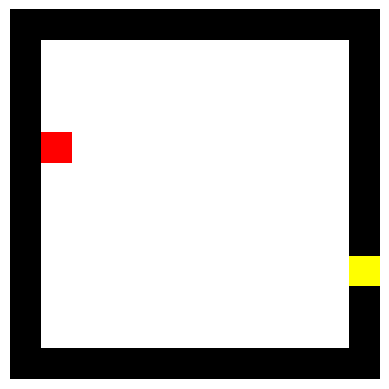

Episode: 8191 
        Avg Iterations (last 4096 episodes): 17.02 
        Avg Score (last 4096): 0.3380 
        SnakeLength: 1.10546875 
        Eplsilon: 0.8926582056957006 
        Learning Rate: 0.01
        


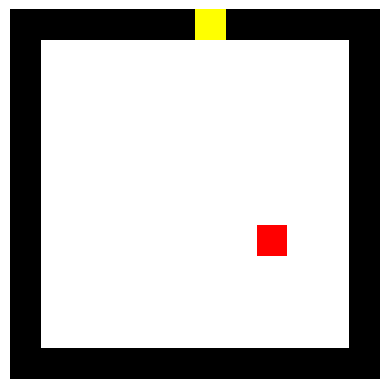

Episode: 12287 
        Avg Iterations (last 4096 episodes): 16.43 
        Avg Score (last 4096): 0.3222 
        SnakeLength: 1.093994140625 
        Eplsilon: 0.8890093538107648 
        Learning Rate: 0.01
        


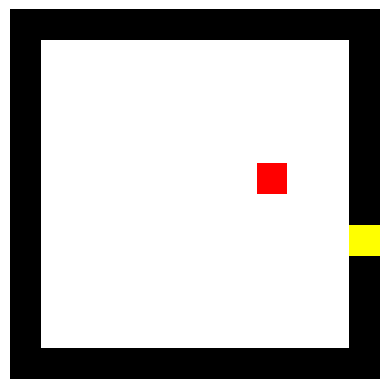

Episode: 16383 
        Avg Iterations (last 4096 episodes): 16.59 
        Avg Score (last 4096): 0.2971 
        SnakeLength: 1.097412109375 
        Eplsilon: 0.8853754170635548 
        Learning Rate: 0.01
        


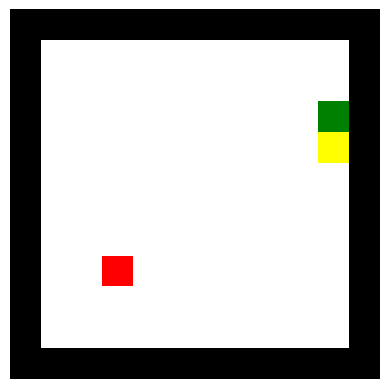

Episode: 20479 
        Avg Iterations (last 4096 episodes): 16.76 
        Avg Score (last 4096): 0.3246 
        SnakeLength: 1.10595703125 
        Eplsilon: 0.8817563344865778 
        Learning Rate: 0.01
        


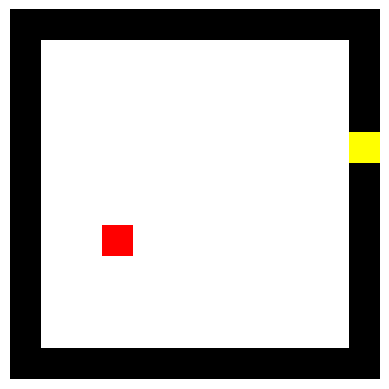

Episode: 24575 
        Avg Iterations (last 4096 episodes): 16.26 
        Avg Score (last 4096): 0.3343 
        SnakeLength: 1.10205078125 
        Eplsilon: 0.8781520453615635 
        Learning Rate: 0.01
        


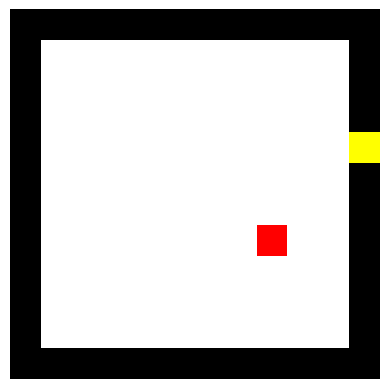

Episode: 28671 
        Avg Iterations (last 4096 episodes): 16.02 
        Avg Score (last 4096): 0.3092 
        SnakeLength: 1.0986328125 
        Eplsilon: 0.8745624892184263 
        Learning Rate: 0.01
        


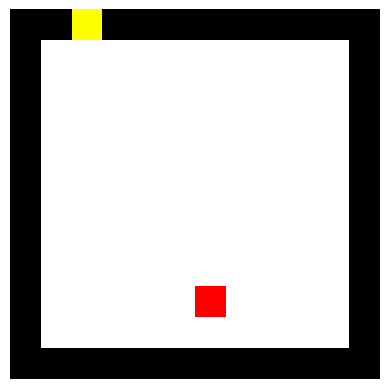

Episode: 32767 
        Avg Iterations (last 4096 episodes): 16.18 
        Avg Score (last 4096): 0.3382 
        SnakeLength: 1.1005859375 
        Eplsilon: 0.870987605834262 
        Learning Rate: 0.01
        


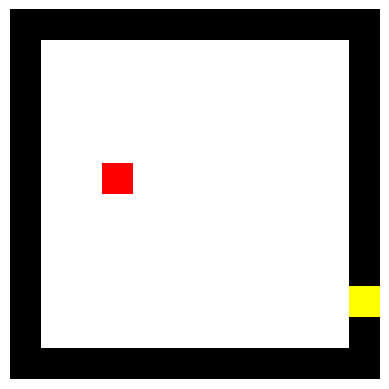

Episode: 36863 
        Avg Iterations (last 4096 episodes): 15.88 
        Avg Score (last 4096): 0.3362 
        SnakeLength: 1.104736328125 
        Eplsilon: 0.8674273352323396 
        Learning Rate: 0.01
        


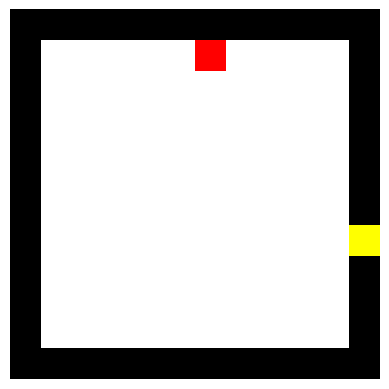

Episode: 40959 
        Avg Iterations (last 4096 episodes): 16.78 
        Avg Score (last 4096): 0.3423 
        SnakeLength: 1.101806640625 
        Eplsilon: 0.8638816176810846 
        Learning Rate: 0.01
        


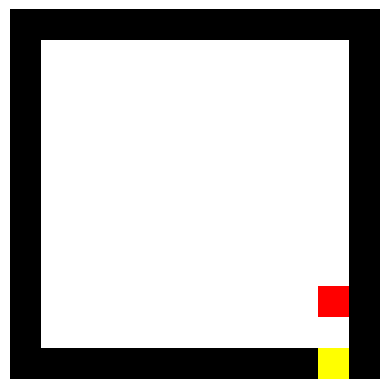

Episode: 45055 
        Avg Iterations (last 4096 episodes): 15.46 
        Avg Score (last 4096): 0.2635 
        SnakeLength: 1.087890625 
        Eplsilon: 0.8603503936930882 
        Learning Rate: 0.01
        


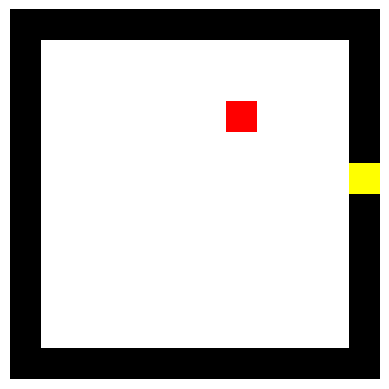

Episode: 49151 
        Avg Iterations (last 4096 episodes): 16.51 
        Avg Score (last 4096): 0.3011 
        SnakeLength: 1.09423828125 
        Eplsilon: 0.8568336040240981 
        Learning Rate: 0.01
        


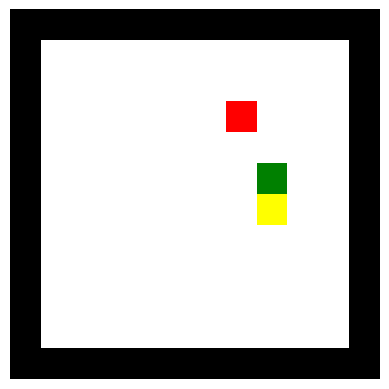

Episode: 53247 
        Avg Iterations (last 4096 episodes): 15.77 
        Avg Score (last 4096): 0.3039 
        SnakeLength: 1.097412109375 
        Eplsilon: 0.853331189672033 
        Learning Rate: 0.01
        


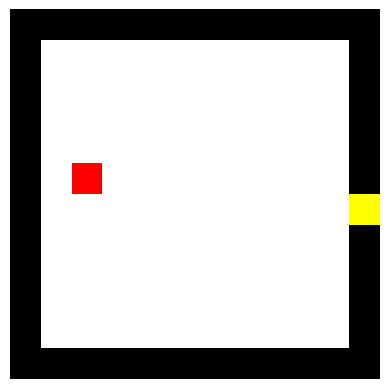

Episode: 57343 
        Avg Iterations (last 4096 episodes): 16.01 
        Avg Score (last 4096): 0.2934 
        SnakeLength: 1.098388671875 
        Eplsilon: 0.8498430918759871 
        Learning Rate: 0.01
        


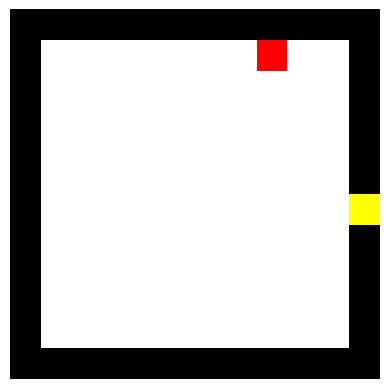

Episode: 61439 
        Avg Iterations (last 4096 episodes): 15.68 
        Avg Score (last 4096): 0.3052 
        SnakeLength: 1.098388671875 
        Eplsilon: 0.8463692521152568 
        Learning Rate: 0.01
        


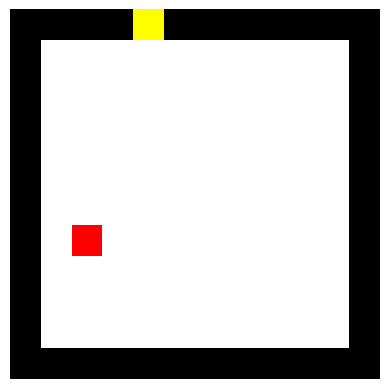

Episode: 65535 
        Avg Iterations (last 4096 episodes): 15.50 
        Avg Score (last 4096): 0.2983 
        SnakeLength: 1.102783203125 
        Eplsilon: 0.8429096121083343 
        Learning Rate: 0.01
        


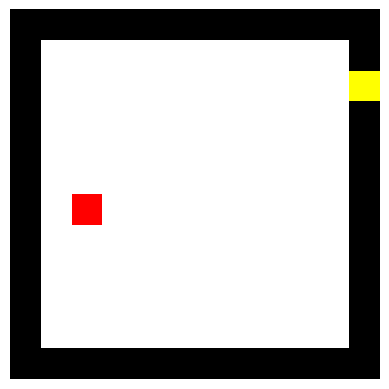

Episode: 69631 
        Avg Iterations (last 4096 episodes): 15.74 
        Avg Score (last 4096): 0.2899 
        SnakeLength: 1.09423828125 
        Eplsilon: 0.8394641138119574 
        Learning Rate: 0.01
        


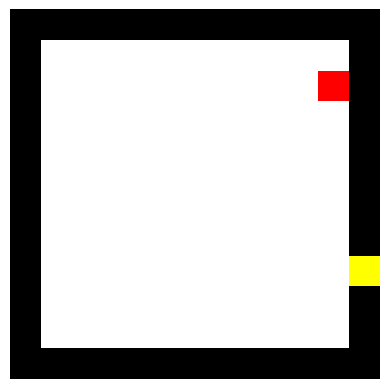

Episode: 73727 
        Avg Iterations (last 4096 episodes): 14.91 
        Avg Score (last 4096): 0.2864 
        SnakeLength: 1.087646484375 
        Eplsilon: 0.8360326994201186 
        Learning Rate: 0.01
        


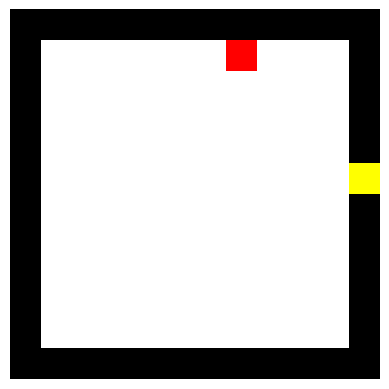

Episode: 77823 
        Avg Iterations (last 4096 episodes): 15.50 
        Avg Score (last 4096): 0.2983 
        SnakeLength: 1.100830078125 
        Eplsilon: 0.8326153113630999 
        Learning Rate: 0.01
        


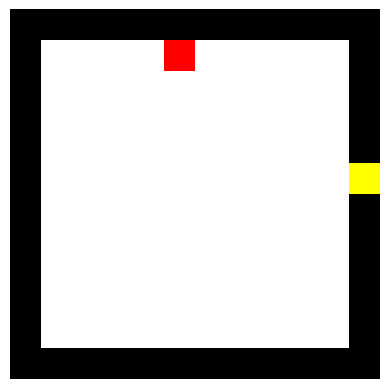

In [ ]:
# Hyperparameters

input_dim = TOTAL_GRID_SIZE**2 + 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Number of GPUs: {torch.cuda.device_count()}')
print(f'Device: {device}')
agent = DQNAgent(input_dim=input_dim , output_dim=4) # Fill input dimension
action_mapping = {
            0: Direction.UP,
            1: Direction.DOWN,
            2: Direction.LEFT,
            3: Direction.RIGHT
        }
iterations_plot_list = []
scores_plot_list = []
moving_avg_iterations = deque(maxlen=PRINT_FREQUENCY)
moving_avg_scores = deque(maxlen=PRINT_FREQUENCY)
moving_avg_length = deque(maxlen=PRINT_FREQUENCY)
for episode in range(EPISODES):
    set_seed(SEED + episode)
    starting_head_location = random.choice(list(EMPTY_GRID_SET))
    starting_apple_location = random.choice(list(EMPTY_GRID_SET - set(starting_head_location)))
    iteration_count = 0
    done, snake_queue, apple_location, distance_traveled_to_apple, distance_to_apple, score = initialize_game(starting_head_location, starting_apple_location)
    state = encode_state(snake_queue, apple_location, distance_traveled_to_apple, score)

    while not done:
        iteration_count += 1
        action_index = agent.get_action(state)
        done, snake_queue, apple_location, distance_traveled_to_apple, new_score = update_state(snake_queue, apple_location, distance_traveled_to_apple, action_mapping[action_index], score)
        next_state = encode_state(snake_queue, apple_location, distance_traveled_to_apple, new_score-score)
        agent.buffer.push(next_state, action_index, new_score - score, next_state, done)
        agent.update()
        state = next_state
        #game_grid = [state[i:i+TOTAL_GRID_SIZE] for i in range(0, TOTAL_GRID_SIZE**2, TOTAL_GRID_SIZE)]
        #plot_game_board(game_grid)
        score = new_score
    
    moving_avg_iterations.append(iteration_count)
    moving_avg_scores.append(score)
    moving_avg_length.append(len(snake_queue))
    
    plot_board = True
    if ((episode + 1) % PRINT_FREQUENCY == 0):
        avg_iterations = sum(moving_avg_iterations) / len(moving_avg_iterations)
        avg_score = sum(moving_avg_scores) / len(moving_avg_scores)
        avg_length = sum(moving_avg_length)/ len(moving_avg_length)
        iterations_plot_list.append(avg_iterations)
        scores_plot_list.append(avg_score)
        print(f'''Episode: {episode} 
        Avg Iterations (last {PRINT_FREQUENCY} episodes): {avg_iterations:.2f} 
        Avg Score (last {PRINT_FREQUENCY}): {avg_score:.4f} 
        SnakeLength: {avg_length} 
        Eplsilon: {agent.get_epsilon()} 
        Learning Rate: {agent.get_lr()}
        ''')
        if plot_board:
            game_grid = [state[i:i+TOTAL_GRID_SIZE] for i in range(0, TOTAL_GRID_SIZE**2, TOTAL_GRID_SIZE)]
            plot_game_board(game_grid)
    agent.decay_epsilon()
    if episode % 2**8 == 0: # Sync every 10 episodes
        agent.sync_target()

plot_series(iterations_plot_list, scores_plot_list)
game_grid = [state[i:i+TOTAL_GRID_SIZE] for i in range(0, TOTAL_GRID_SIZE**2, TOTAL_GRID_SIZE)]
plot_game_board(game_grid)

Absolutely! Systematic hyperparameter tuning and debugging is crucial in reinforcement learning to ensure efficient learning. Let's outline a structured approach:

1. Baseline and Simplification:
Start with a simpler version of the problem. Perhaps a smaller grid or an environment where the apple is always in the same place.
Make the network as simple as possible. Once you see it learning, gradually increase its complexity.
2. Diagnosis:
Visualizations: Visualize the agent's decisions over time. Is it exploring enough? Is it getting stuck in a loop?
Reward Analysis: Print the rewards obtained during each step. Is the agent getting the expected rewards for its actions?
Gradient Checks: Monitor the magnitude of the gradients. If they're too small, you might be dealing with vanishing gradients; if they're too large, exploding gradients.
Q-value Analysis: Plot the Q-values over time. Are they diverging or converging? Are they increasing for the correct actions and decreasing for the incorrect ones?
Action Distribution: Check the distribution of actions taken by the agent. Is it too biased towards one action? This can indicate that the agent has found a loophole in the reward system or isn't exploring enough.
3. Hyperparameter Tuning:
Grid Search: Start with broader ranges for hyperparameters like learning rate, epsilon decay, etc., and then narrow down.
Random Search: Sometimes better than grid search, as it can explore the hyperparameter space more diversely.
Bayesian Optimization: Tools like Optuna, Hyperopt, or frameworks like Ray Tune can be very efficient for hyperparameter tuning in RL.
4. Incremental Changes:
Change one thing at a time and observe its impact. If you adjust multiple things and something goes wrong (or right), you won't know what caused it.
5. Check Environment Dynamics:
Ensure there are no bugs in the environment itself, as these can majorly affect learning.
6. Reproducibility:
Start with established, reproducible baselines or reference implementations. If a well-known algorithm doesn't work in your environment, it's a strong signal that something might be off.
7. Alternative Approaches:
Curriculum Learning: Start with easier tasks and gradually move to complex ones.
Reward Shaping: Sometimes, a more frequent, intermediate reward can guide the agent better than a sparse reward.
Transfer Learning: If you have a model trained on a similar task, you can fine-tune it on your current task.
8. Review Model Architecture:
Ensure that the architecture is suitable for the task. Sometimes a simple feed-forward network might not suffice, and you might need recurrent layers or other architectures.
Check the initialization methods for your neural network layers.
9. Regular Monitoring and Logging:
Tools like TensorBoard or Weights & Biases can be invaluable. Log scalars like loss, average reward, epsilon, and more complex data like histograms of network weights, Q-values, or even images of the game state.
Remember, in RL, especially in environments with high variance, it's often valuable to run multiple seeds (starting points) and average the results to ensure the changes you're observing aren't just due to randomness.


Your model's performance seems to be fluctuating with a limited increase in average score and snake length over the episodes. Let's troubleshoot:

Learning Rate and Decay: Your learning rate LEARNING_RATE = 1e-2 is relatively high for a deep learning problem, especially when it is decaying at every episode. As the learning rate drops, the model might make smaller and smaller updates, leading to slow or stalled learning. Consider using a slightly higher learning rate or decaying it less frequently.

Reward Structure: The reward structure plays a critical role in RL. Let's analyze:

MOVEMENT_BONUS: It's quite high for just moving. This might encourage the snake to move around without necessarily targeting the apple.
WALL_PENALTY: It's a good idea to penalize the snake for hitting the wall. However, consider the magnitude. Is -10 too low or too high relative to other rewards?
WIN_BONUS: This bonus is huge compared to other rewards. While this can incentivize winning, the agent might never achieve this state if it's too focused on smaller rewards (like movement).
Epsilon Decay: Your epsilon is decaying at a rate of 1e-5 which means it will approach its minimum quite slowly. This means that exploration will continue to dominate for many episodes. It might be worthwhile to allow the agent to exploit its knowledge sooner by adjusting the decay rate or setting a threshold episode after which epsilon decreases more rapidly.

Network Architecture: We haven't seen the architecture of the DQN. The model's complexity, layers, and activation functions can impact its ability to learn. Consider experimenting with different architectures.

Replay Buffer: How is your buffer implemented? Too small a buffer can cause the agent to forget previous experiences quickly. On the other hand, a very large buffer might make the agent focus too much on older experiences. Also, the sampling strategy can make a difference. Prioritized experience replay can sometimes enhance learning.

Initialization: How are the weights of your DQN initialized? Poor initialization can hamper learning.

Training Frequency: Consider adjusting how often you sync the target network with the DQN. Syncing too frequently can lead to chasing a moving target, while too infrequent can slow down learning.

Exploration vs. Exploitation: Printing the epsilon value periodically will give insight into how much exploration vs. exploitation is being done. If it's still in a high exploration mode, consider adjusting the decay.

Environment Dynamics: Ensure that the environment (like apple placement, snake initialization) does not have any bugs or undesired behaviors that can affect learning.

Visual Analysis: Sometimes, it's beneficial to visually observe the agent in action. Look for any repetitive or strange behaviors.

Grad Check: Ensure gradients aren't vanishing or exploding during backpropagation. This can be done by checking the norms of the gradients.

After making any changes, it's essential to retrain and observe the agent's behavior. Remember, deep reinforcement learning can be sensitive to hyperparameters and often requires multiple iterations and tweaks for convergence.